## Read climate reanalysis data

We usually use the <code>netCDF4</code> or <code>xarray</code> packages for this task.

In [1]:
# Import packages
import os
import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import rasterio
import xarray

In [4]:
# Read data
xds = xarray.open_dataset('data/usa_t2m_tcc_2020.nc', decode_coords='all')

In [5]:
xds

<xarray.Dataset>
Dimensions:    (longitude: 233, latitude: 99, time: 1464)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-12-31T18:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-01-05 17:55:44 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

This looks a bit overwelming but it nice way to store gridded data. Below is a schematic of what an xarray data structure represents.


<br>
<div>
<img src="images/xarray_data_structures.png" width="600"/>
</div>

In [28]:
# Print the time period of the data
print('The data ranges from %s to %s' %(xds['t2m']['time'].values.min(), xds['t2m']['time'].values.max()))

The data ranges from 2020-01-01T00:00:00.000000000 to 2020-12-31T18:00:00.000000000


So we know the data spans one year but there are 1464 dimensions in the time variable. This means that the reanalysis data must have a temporal resolution of 6 hours. So before we continue we will resample to daily temporal resolution.

In [29]:
xds_daily = xds.resample(time='1D').mean()
xds_daily

<xarray.Dataset>
Dimensions:    (time: 366, longitude: 233, latitude: 99)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74
Data variables:
    t2m        (time, latitude, longitude) float32 280.6 281.4 ... 296.3 296.2
    tcc        (time, latitude, longitude) float32 0.9765 0.8814 ... 0.2124

### Plot climate reanalysis data

Now each layer in the dataset corresponds to a single day. Let's plot the air temperature and cloud cover for the day which the Landsat image was acquired (August 14, 2020).

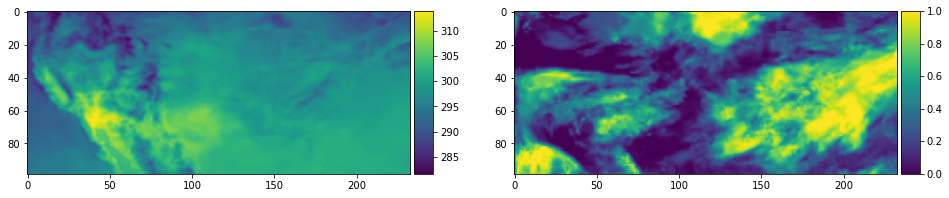

In [30]:
# Plot data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
im1 = ax1.imshow(xds_daily['t2m'][226,:,:])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax2.imshow(xds_daily['tcc'][226,:,:])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

### Weather in Florence, OR

So we know that is was relatively cold, cloud-free day in Florence, just like we see in the Landsat image. But how anomalous were these conditions? We can investigate by finding the nearest climate reanalysis grid cell to Florence, OR. First we will define the latitude and longitude of Florence. 

In [31]:
# Next, find the index of the grid point nearest a specific lat/lon.   
florence_weather = xds_daily.sel(latitude=43.974659, longitude=-124.103142, method='nearest')

/home/johnny/anaconda3/envs/lab4/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/johnny/anaconda3/envs/lab4/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


In [32]:
# Note: Aug 14 is DOY 226
print('Cloud cover in Florence on Aug 14, 2020 = %.2f %%' % (florence_weather['tcc'][226].values * 100))

Cloud cover in Florence on Aug 14, 2020 = 0.02 %


In [33]:
fahrenheit = (florence_weather['t2m'][226].values - 273.15) * 9/5 + 32
print('Air temperature in Florence on Aug 14, 2020 = %.2f F' % (fahrenheit))

Air temperature in Florence on Aug 14, 2020 = 62.25 F


### Plot time series

These values look about right. Now we can plot the time series.

Text(0, 0.5, 'Cloud cover (%)')

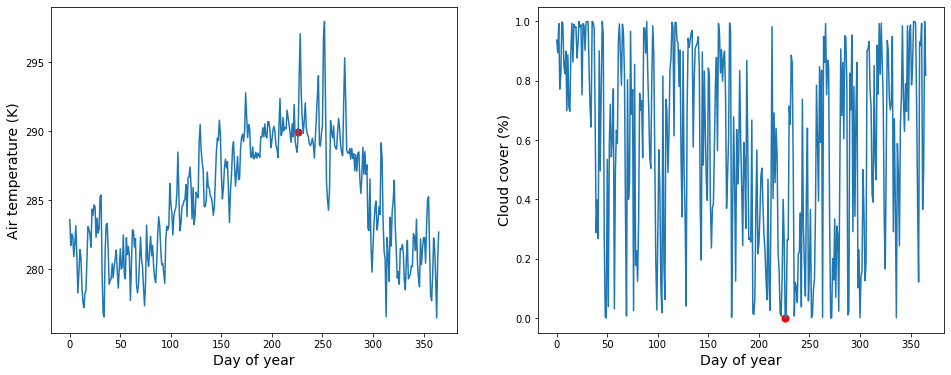

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.plot(florence_weather['t2m'])
ax1.scatter(226, florence_weather['t2m'][226], s=50, color='r')
ax1.set_xlabel('Day of year', fontsize=14)
ax1.set_ylabel('Air temperature (K)', fontsize=14)

ax2.plot(florence_weather['tcc'])
ax2.scatter(226, florence_weather['tcc'][226], s=50, color='r')
ax2.set_xlabel('Day of year', fontsize=14)
ax2.set_ylabel('Cloud cover (%)', fontsize=14)

### Find mean values

It was a pretty nice warm day in Florence on Aug 14, 2020 relative to mean annual conditions. But what is the actual mean?

In [35]:
mean_temp = (florence_weather['t2m'].mean() - 273.15) * 9/5 + 32
print('Mean air temp. in Florence in 2020 = %.2f F' % (mean_temp))

Mean air temp. in Florence in 2020 = 53.55 F


In [36]:
mean_cloud = florence_weather['tcc'].mean()
print('Mean cloud cover in Florence in 2020 = %.2f %%' % (mean_cloud * 100))

Mean cloud cover in Florence in 2020 = 58.76 %


Finally, let's calculate how many days had less than 20% cloud cover in Florence

In [37]:
days = np.sum(florence_weather['tcc'] < 0.2).values
print('There were %.0f days with less than 20%% cloud cover in 2020' % days)

There were 61 days with less than 20% cloud cover in 2020


***********
## Question 1 (10 points): 

Now that we have gone through some examples in the lecture and lab we are ready to apply some of these methods ourselves. Start by making a **new** `jupyter notebook` called `lab4_submission.ipynb` and complete the following tasks. 

Find the following numbers in the climate reanalysis dataset:

* a) the air temperature (in F) **and** cloud cover (in %) in Florence, OR (in 2020) on **January 31, 2020**?
* b) the air temperature (in F) **and** cloud cover (in %) in **Eugene, OR** (in 2020) on **February 15, 2020**?

You can use the following table to convert from a **date** to a **day-of-year**: https://landweb.modaps.eosdis.nasa.gov/browse/calendar.html


*******
## Question 2 (20 points):

Find the following grid cells in the climate reanalysis dataset and provide the lat/lons **and** a rough location of where they are located. 

* a) Highest average air temperature (i.e. hottest place)
* b) Lowest average air temperature (i.e. coldest place)
* c) Highest average cloudiness (i.e. cloudiest place)
* d) Lowest average cloudiest (i.e. least cloudy place)
* e) Place with highest range in **daily** air temperature
* f) Place with the absolute coldest temperature on a single day 

You can copy and paste the lat/lons into Google Maps to find a rough location of where these places are. 

**********

## Question 3 (20 points): 

Display the Landsat image of Florence, OR as:

* a) an **NDVI** image (i.e. (Band 5 - Band 4) / (Band 5 + Band 4))
* b) a **color infrared composite** (i.e. bands 5, 4, 3)

*********

## Question 4 (for grad students/extra credit)

* a) Produce an NDWI histogram for the Landsat image of Florence 
* b) Choose a threshold and produce a binary water mask
* c) Compute the area of water in the image (including ocean)


## Remember to submit your answers to Questions 1, 2 and 3 **by Friday 11:59pm**

In [39]:
# HINT use argmax() or argmin()
max_value = np.mean(xds_daily['t2m'], axis=0).argmax()
index = np.unravel_index(max_value, np.mean(xds_daily['t2m'], axis=0).shape)